In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# Categorical (Non numeric) data

In this module we will learn how to deal with non-numeric data
- categorical
- image
- text

The non-numeric data may be
- the target
- a feature

# Overview
## Goals

We will learn how to do Supervised Learning:Classification

Recall that the target for a Classification problem is a discrete value (as opposed to continous for Regression).

So by it's nature, we will have to deal with non-numeric targets.

We will also deal with non-numeric features

## Plan

- Introduce the Titanic challenge
    - driving example for Classification
    - will continue to use it in our module on Data Transformation
- First pass at the challenge
    - Naive approach, but makes the points
    - Categorical (non-numeric) **binary** target
    - Single non-numeric **binary** feature
- Dealing with non-numeric, non-binary targets
- Dealing with non-numeric, non-binary features
    - Alternative data: images

<img src=external/scipy-2018-sklearn/notebooks/figures/ml_taxonomy.png>


# Ideas



# Non-numerical target: Classification, using the Titanic

## Problem statement
The Titanic was a ship ...

The goal is to predict whether a passenger survives, based on passenger characteristics.

### Binary Classification

In Regression, our target was a continous value.

For Titanic, it is a binary value: Survive/Don't Survive

So we have a non-numerical target with two possible values.

In general, the objective is to choose one value from a set ($\textrm{size}>= 2$) of possible values.

The classifier will produce a number between 0 and 1 indicating the *probability* of being in the class ("1"). If the probability > 50%, the observation is classified (by the `predict` method) as being in the class.

The general problem is *Multi-class classification*.

The way to treat non-numeric values is not obvious and there are many *wrong* ways to do it.

Fortunately, binary non-numerical data is an an easy special case (0 or 1 values)

In the Titanic example, all our non-numerical data will be binary.

We will revisit non-binary non-numerical features later, and the math of Logistic Regression in the Training Models module.

**Aside:** What does the Titanic have to do with Finance or Risk ?
- Defaults (Survival probability of a corporation)
    - Credit risk
- Mortgage pre-payment

## Performance measure

Our performance measure will be **accuracy**, the fraction of correct predictions.


$$
\textrm{Accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{number of predictions} }
$$

There are several drawbacks with this definition, which we will address later.

But let's start with it for now.

In pictures:
$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & TP         & FP \\
\textbf{N} & FN         & TN \\
\end{array}
$$

So

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

## The Data

### Get the data
The data comes in two files
- train
- test

The "Survival" column is ...


### Initial Data Exploration

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

# Sklearn imports

TITANIC_PATH = os.path.join("./external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )


#### First look

Let's examine the first few records to get a feel for the shape of the data.

In [3]:
train_data.columns
train_data.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

How many observation are there ?


In [4]:
(num_obs, num_features) = train_data.shape
print("There are {nr} observations and {nf} attributes (including the target)".format(nr=num_obs, nf=num_features) )

There are 891 observations and 12 attributes (including the target)


Let's try to understand the types of the attributes

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**Non-numeric attributes**

We can see the non-numeric attributes (type is "object") are:
- Name
- Sex
- Cabin
- Embarked

**Data issues: missing attributes**

We can also see that we have some missing data issues to deal with.

Any attribute with less than num_obs values has observations with a missing value in the attribute
- Age
- Cabin
- Embarked


Let's get a sense of the distribution of each attribute

(n.b., `describe` operates *only* on the numeric attributes)

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- You can also observe the attributes with missing values by looking at the "count"
- You can clearly see that Survived is a binary, numerical variable
- Only 38 % of the passengers survived ("mean")

In [7]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

##### Graphical exporation

- Wheter to plot P(Surive|X) or P(X|Survive)
    - related to Naive Bayes
        - P(H|E) = P(E|H) P(H)/P(E)
        - H == "Passenger Survived"
        - E == "Passenger Sex == Male"
        - P(Survived| Sex==Male) = P(Sex==Male | Survived) * P(Survived)/P(Male)
            - P(Sex==Male | Survived)  = P(Sex== Male & Survived)/P(Survived)
                - so RHS ration is prob concitional on feature divied by unconditional prob
- Relate to baseline estimate
    - if P(Surive|Male) == P(Survive|not Male) == P(Survive(, the feature Male is not predictive
        - only predictive in P(Survive|Male) >> P(Survive)
        - equivalent: only predictive if P(Survive|Male) <> P(Surive|Not Male) ??
            - so looking across conditional plots P(Surive|Male) and P(Surive|not Male) tells you if Male is predictive

**Distribution of each attribute**

Let's start by looking at the (unconditional) distribution of the target and some attributes

First let's look at them normalized (i.e, as fractions or probabilities)

In [8]:
def plot_attrs(df, attrs, attr_type="Cat", normalize=True, plot=True):
    """
    Plot/print the distribution of one or more attributes of DataFrame
    
    Parameters
    ----------
    df: DataFrame
    attrs: List of attributes (i.e., column names)
    
    Optional
    --------
    attr_type: String; 
      "Cat" to indicate that the attributes in attrs are Categorical (so use value_counts)
      Otherwise: the attributes must be numeric columns (so use histogram)
    """
    num_attrs = len(attrs)
    ncols=2
    nrows = max(1,round(num_attrs/ncols))
  
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, num_attrs*2))
    
    # Make sure axes is an array (special case when num_attrs==1)
    if num_attrs == 1:
        axes =np.array( [ axes ])
        
    for i, attr in enumerate(attrs):
        if attr_type == "Cat":
            alpha_bar_chart = 0.55
            plot_data = df.loc[:, attr ].value_counts(normalize=normalize).sort_index()
            
            args = { "kind":"bar" } #, "alpha":alpha_bar_chart}
            kind="bar"
        else:
            plot_data = df.loc[:, [attr] ]
            
            args = { "kind":"hist"}
            if normalize:
                args["density"] = True
            kind="hist"
            
        if plot:
            _ = plot_data.plot(title=attr, ax=axes.flatten()[i], **args)
        else:
            print(attr + "\n")
            print(plot_data)
            print("\n")

Next, let's look at them un-normalized, or absolute count

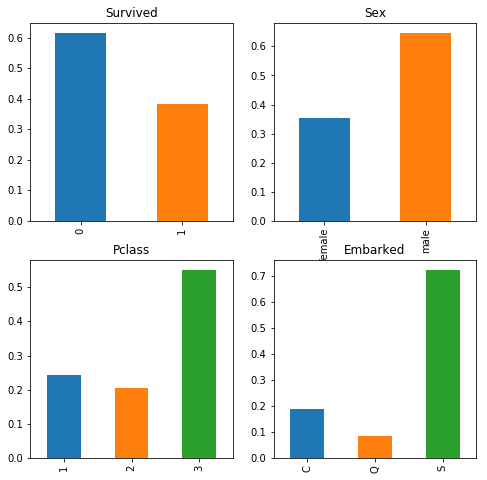

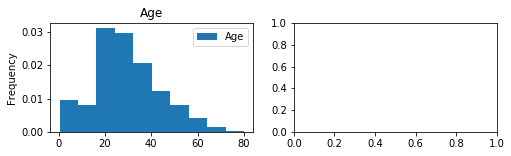

In [9]:
plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True)
plot_attrs(train_data, [ "Age" ], attr_type="Num")

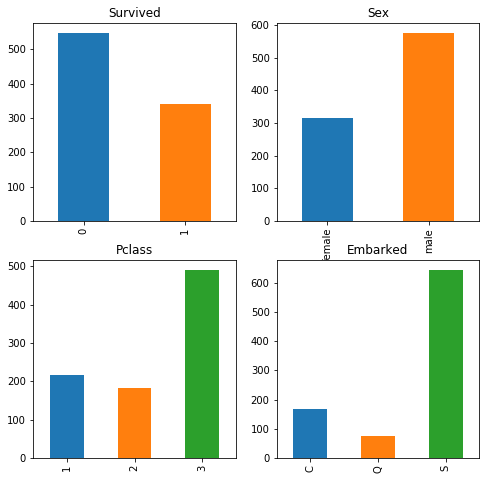

In [10]:
plot_attrs(train_data, [ "Survived", "Sex", "Pclass", "Embarked" ], attr_type="Cat", plot=True, normalize=False
          )

Not sure how to interpret "Cabin".  Maybe if we had a map of the ship we could translate into a location.

Let's just omit this attribute for now.

If you are a diligent Data Scientist you can find this image, which is revealing
- Worst cabins (pink, Third class) were dispersed between front and back
- Best cabins (white, First class) were dispersed between above/below deck
- Mid cabins(yellow, Second Class) were *not* near point of front
![Titanic cabins](images/Titanic_cabin_layout.jpg)

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

*Questions* that might help us with feature engineering:
- why might cabin location matter ?
- why might point of embarcation matter ?

In [11]:


def plot_cond( df, var, conds, ax, normalize=True):
    """
    Plot probability of a value in column var of DataFrame df, conditional on conditions expressed in conds
    
    Parameters
    ----------
    df: DataFrame
    var: String.  Name of column in df whose density we will plot
    conds: Dictionary
    - keys are Strings, which are names of columns in df
    - values are values that could be compared with column at the key
    
    
    """
    plot_data = df.copy()
    title_array = []
    
    for cond, val in conds.items():
        title_array.append( "{c}={v}".format(c=cond, v=val))
        plot_data = plot_data.loc[ plot_data.loc[:, cond] == val, : ]
        
        args = { "kind": "bar"}
        
    
    plot_data = plot_data.loc[:, var ]
    
    title = ", ".join(title_array)
    title = "Prob({v} | {t})".format(v=var, t=title)
    plot_data.value_counts(normalize=normalize).sort_index().plot(title=title, ax=ax, **args)
    
def plot_conds(df, specs):
    """
    Print multiple conditional plots using plot_cond
    
    Parameters
    -----------
    df: DataFrame
    specs: List. Each element of the list is a tuple (var, conds)
    -  each element of the list generates a call to plot_cond(df, var, conds)
    """
    num_specs = len(specs)
    ncols=3
    nrows = max(1,round(.4999 + num_specs/ncols))
  
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, num_specs*1.5))
    
    # Make sure axes is an array (special case when num_attrs==1)
    if num_specs == 1:
        axes =np.array( [ axes ])
        
    for i, spec in enumerate(specs):
        if spec is None:
            continue
        (var, conds) = spec
        plot_cond(df, var, conds, ax=axes.flatten()[i])

##### Conditional survival probability (condition on single attribute)

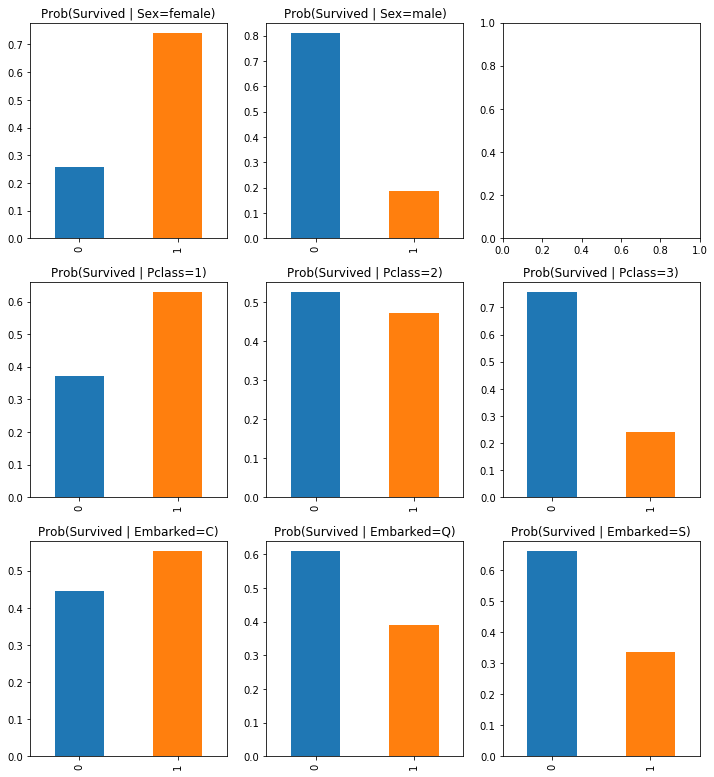

In [12]:
plot_conds(train_data, [ ("Survived", { "Sex": "female"}),
                         ("Survived", { "Sex": "male"}),
                         None,
                         ("Survived", { "Pclass": 1}),
                         ("Survived", { "Pclass": 2}),
                         ("Survived", { "Pclass": 3}),
                        
                         ("Survived", { "Embarked":"C"}),
                         ("Survived", { "Embarked":"Q"}),
                         ("Survived", { "Embarked":"S"}),
                       ]
          )


Interesting !
- Women are 4 times as likely to survive
- NOT being in the lowest Class doubles or triples your survival probability
- Embarking at Cherbourg increased your probabiity or surviving
    - WHY ? Is there a correlation between Class and point of embarcation maybe ?
    
Preview: There may also be lessons here for create substitutes for missing data

##### Conditional survival probability (condition on multiple attributes)

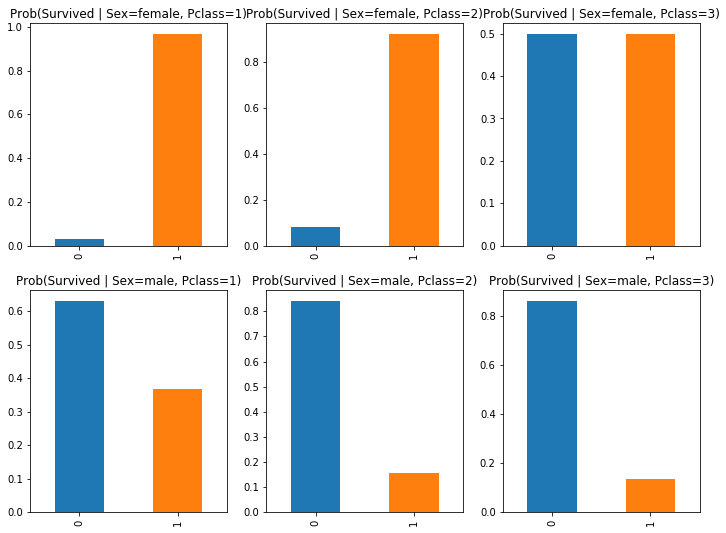

In [13]:
plot_conds(train_data, [
                         ("Survived", { "Sex": "female", "Pclass": 1}),
                         ("Survived", { "Sex": "female", "Pclass": 2}),
                         ("Survived", { "Sex": "female", "Pclass": 3}),
    
                         ("Survived", { "Sex": "male", "Pclass": 1}),
                         ("Survived", { "Sex": "male", "Pclass": 2}),
                         ("Survived", { "Sex": "male", "Pclass": 3}),
                       ])

<div class="alert alert-block alert-info">
    <b>Aside</b>:   How does pd.groupby() work ?

The Pandas Split-Apply-Combine pattern is very powerful
- This is very SQL-like, for those who have used databases
- Below is some simpler Pandas code to show exactly how it works

In [14]:
# Partition by the attribute "Sex"
males   = train_data[ train_data["Sex"] == "male"]
females = train_data[ train_data["Sex"] == "female"]

# Aggregate within each group: count,mean.  n.b., only doing this for the "Survived" column
count_males, count_females = males.shape[0], females.shape[0]
survival_males, survival_females = males["Survived"].mean(), females["Survived"].mean()

print( "male\t{c}\t{m:0.4f}".format(c=count_males, m=survival_males) )
print( "female\t{c}\t{m:0.4f}".format(c=count_females, m=survival_females) )

# Or, use the pd.groupby
train_data.groupby("Sex").agg(["mean", "count"])["Survived"]


male	577	0.1889
female	314	0.7420


,mean,count
Sex,,
female,0.742038,314
male,0.188908,577


### Test data

The train/test split was done for us: it came as two separate files

We might later choose to combine the two and do our own split (or better yet: multiple splits) but for now, we'll take what we'ere given

## Prepare the data

Our first model will use the following features
- Pclass
- Sex
- Age
- SibSp: passenger's number of "same-level" relatives (Sibling, Spouse)
- Parch: passenger's number of "different-level" relatives (Parent, Child)
- Fare

### Data cleaning

Our initial data exploration revealed some attributes with missing data
- Age
- Cabin
- Embarked

We will address various strategies for dealing with missing data in the module on Data Transformations.

For now, we will take a very simple (and naive) approach
- for numeric attributes: use the median value
- for non-numeric attributes: use the most frequent value

### Data Tranformations

We will do minimal transformation for now (more to come in the module on Data Transformations)
- deal with missing values
- convert the categorical, binary attribute "Sex" to a number: 0:male, 1: female

This is also very naive (and, technically wrong !  Ask me later !) but it will allow us to make our key points with minimum distraction.

#### A sophisticated pipeline

We introduced the <u>concept</u> of Transformation Pipelines in the previous lecture.  Key points
- a pipeline is a sequence of transformations
- the same transformations are applied to the Train and Test datasets
    - but *separately* **not** together

We also showed how sklearn implements the concept:
- Pipeline transform Pandas DataFrame, not NumPy matrices !
- One pipeline to transform numeric features
- One pipeline to transform categorical features
- A "union" pipeline to do both

We will do a review of the complex pipeline we introduced in the previous lecture

Again, the *concept* of pipeline (sequence of transformations) is independent of an API
- don't get caught up on `sklearn`'s method, just absorb the concpets

#### The numeric pipeline

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

num_features = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( num_features )),
        ("imputer", SimpleImputer(strategy="median")),
    ])

Let's see what the numeric pipleine produces

In [16]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

#### The non-numeric pipeline

**WARNING**: I'm doing a little cheating in the non-numeric pipeline

In [17]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

class SexToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        I am really cheating here ! Am ignoring all columns except for "Sex"
        """
        
        # To see that I am cheating, look at the number of columns of X !
        print("SexToInt:transform: Cheating alert!, X has {c} columns.".format(c=X.shape[-1]) )
        
        sex = X["Sex"]
        X["Sex"] = 0
        X[ sex == "female" ] = 1
        
        return(X)

cat_features = ["Sex", "Pclass" ]

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector( cat_features )),
        ("imputer", MostFrequentImputer()),
        ("sex_encoder", SexToInt() ),
    ])

Let's see what the categorical pipeline produces

In [18]:
cat_pipeline.fit_transform(train_data).head()

SexToInt:transform: Cheating alert!, X has 2 columns.


,Sex,Pclass
0,0,3
1,1,1
2,1,1
3,1,1
4,0,3


`FeatureUnion` glues together the Numeric and Categorical transformations along column dimension

#### The Union pipeline: both numeric and non-numeric pipelines together

In [19]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Let's look at the result of applying the `preprocess_pipeline`

In [20]:
X_train = preprocess_pipeline.fit_transform(train_data)

X_train.shape
X_train

# X_train is now an ndarray, so really can't discern columns, but are in same order as in Feature Union
# so first the num_features, then cat_features
# Can verify this by looking at train_data
all_features = num_features.copy()
all_features.extend(cat_features)
train_data.loc[:, all_features ] .head()

SexToInt:transform: Cheating alert!, X has 2 columns.


(891, 6)

array([[22.    ,  1.    ,  0.    ,  7.25  ,  0.    ,  3.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ,  1.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  1.    ,  1.    ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ,  1.    ,  1.    ],
       [26.    ,  0.    ,  0.    , 30.    ,  0.    ,  1.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ,  0.    ,  3.    ]])

,Age,SibSp,Parch,Fare,Sex,Pclass
0,22.0,1,0,7.2500,male,3
1,38.0,1,0,71.2833,female,1
2,26.0,0,0,7.9250,female,3
3,35.0,1,0,53.1000,female,1
4,35.0,0,0,8.0500,male,3


## Select and Train the model

OK, we have identified features and now want to predict Survival. 

How do we do it ?

Remember that a Regression problem produces a continous output but our problem has a binary output.

We can use a specialized form of Regression called Logistic Regression.  This produces a continous
output in the range $[0,1]$, which we can interpret as a probability of survival.

If the probability produced exceeds $0.5$, we'll predict "Survive".

We will use the Linear regression equation to produce a "score" $s$ (where a higher score implies a higher probablility of Survival).  

$$ s = \Theta^T \cdot x $$ 
This score will be converted into a probability using the *sigmoid* function

$$
\sigma(s)  ={1 \over { 1 + e^{-s}} }
$$

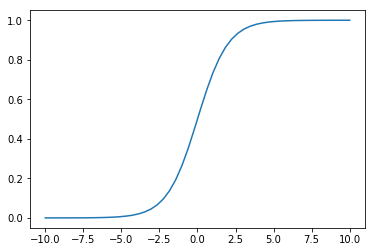

In [21]:
s = np.linspace(-10,10, 50)
sigma_s = 1/(1 + np.exp(- s))

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_ = ax.plot(s, sigma_s)

So our hypothesis is

$$ h_\theta(x) = \sigma( s )$$ 

We will refer to 

$$ \hat{p} = h_\theta(x) = \sigma(s)$$

as the **probability** of surival
and our prediction will be 

$$
\hat{y} = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p} < 0.5 \\
    1 & \textrm{if } \hat{p} \ge 0.5
    \end{array}
    }
\right.
$$

### Relation between score $s$ and probability $\hat{p}$
Score 
$$s = \Theta^T \cdot x$$
is related to the odds ratio 
$$\frac{\hat{p}}{1-\hat{p}}$$

$$
\begin{array}{llll}
\hat{p} \over {1- \hat{p}} & = &  { 1 \over { 1 + e^{-s} } } \over { 1 -  {1 \over { 1 + e^{-s} } } } \\
& = & { 1 \over { 1 + e^{-s} } } \over { {1 + e^{-s}  -1} \over {1 + e^{-s}} } \\
& = & 1 \over {e^{-s}} \\
& = & e^{s}
\end{array}
$$



so 
$$\textrm{log}\left(\hat{p} \over {1- \hat{p}} \right) = s
$$

That is, the score $s$ is the log of the odds ratio.  This will help us interpret the coefficients $\Theta$.

### Cost function for Logistic Regression

Consider a single observation with target $y$

We assign the following cost to our prediction $\hat{y}$

$$
\begin{array}{lll}
c(\theta) & = &
\left\{
{
    \begin{array}{ll}
    - \textrm{log}(\hat{p}) & \textrm{if } & y = 1 \\
    - \textrm{log}(1-\hat{p})     & \textrm{if } & y = 0 \\
    \end{array}
}
\right.
& = & - \left( y*\textrm{log}(\hat{p}) + (1-y) * \textrm{log}(1-\hat{p}) \right)
\end{array}
$$

and over the entire training set of size $m$

$$
J(\theta) = 
\frac{1}{m} 
\sum_{i=1}^m 
\left(
{ y^i * \textrm{log} (\hat{p}^i) + (1-y^i) * \textrm{log}(1-\hat{p}^i)}
\right)
$$

**Intuition**

- if $y^i = 1$
    - the second addend is 0
    - we want the first addend to be small. i.e.,
        - $\hat{p}^i$ to be $1$, so that $\textrm{log}( \hat{p}^i) = 0$
- if $y^i = 0$
    - the first addend is 0
        - we want the second addend to be small, i.e., 
            - $\hat{p}^i$ to be $0$, so that  $\textrm{log}( 1 - \hat{p}^i) = 0$

Note, this is an instance when the Performance Measure (Accuracy) and the Cost Function are not identical.

n.b., they are close though.  Using the intuition above, you can see that the Cost Function is trying to force a high probability to the correct prediction (i.e, the accurate one).  

The key difference is that Accuracy is not differentiable, but the Cost Function is.  So we can apply traditional, derivative-based optimization techniques to the Cost Function.


In [22]:
y_train = train_data["Survived"]

### Logistic Regression classifier

Let's instantiate a `LogisticRegression` classifier

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 

# New version of sklearn will give a warning if you don't specify a solver (b/c the default solver -- liblinear -- will be replaced in future)
logistic_clf = linear_model.LogisticRegression(solver='liblinear')

### More models, more fun ! Same price !

#### SVM Classifier

In [24]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")

#### Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### Train the models: The power of a consistent API - training many models as easy as training one

In [26]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    print("Model: ", name)
    X_train = preprocess_pipeline.fit_transform(train_data)
    clf.fit(X_train, y_train)
    
    X_test = preprocess_pipeline.transform(test_data)
    y_pred = clf.predict(X_test)

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    scores.mean()

Model:  Logistic
SexToInt:transform: Cheating alert!, X has 2 columns.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

SexToInt:transform: Cheating alert!, X has 2 columns.


0.7890208262399273

Model:  SVM
SexToInt:transform: Cheating alert!, X has 2 columns.


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SexToInt:transform: Cheating alert!, X has 2 columns.


0.7318786176370445

Model:  Random Forest
SexToInt:transform: Cheating alert!, X has 2 columns.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

SexToInt:transform: Cheating alert!, X has 2 columns.


0.7970375099307684

Be sure to run the test set through the pipeline that was fit to the train set !

## Feature engineering

We really didn't do any feature "engineering", just some minor transformations
- missing data
- dealing with non-numeric "Sex" feature
    - Sex is a categorical (Non-numeric) feature with only two possible values, which we translate into $(0,1)$
    - A fuller discussion of categorical features (and targets) will follow

### Feature engineering: Preview, Coming Attractions
We'll spend a lot more time on this next week but, for now, just a taste.

For many models (e.g., Regression-like) the value of a feature it related to its' importance.
That is, if the observation's feature has value 100, it contributes twice as much to a linear combination as a value of 50

But is this stricly true ? Does an Age of 25 really differ at all from an Age of 26 ?

Might be able to improve things using "buckets": all Ages within a range (bucket) are given the same value
So the model will try to make distinctions across buckets, but not within bucket

In [27]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


Wow ! Children below the age of 15 had a much better chance of survival.  (And it doesn't pay to be old when disaster strikes!)

We would be hard pressed to see this using Age as a continous variable

# What if the target has more than 2 classes ? Multinomial Classification

So far, we have a binary classifier.  What to do if the target has more than $K > 2$ classes ?

Just for notation, let's refer to the class labels as $1, .., K$

This is called **Multinomial** or **Multiclass** Classification

Some models (e.g. Decision Trees) can handle this directly.

For those that can't, we can adapt a binary classifier:
- One versus All (**OvA**):
    - create $K$ binary classifiers, one for each class label
        - Use the $i^{th}$ binary classifier to predict: Is $i$, or is not $i$
    - predict the class whose binary classifier yields the highest probability
- One versus One (**OvO**)
    - create $ K \cdot (K-1)/2$ binary classifiers, one for each pair of class labels
    - predict the class that wins in the most paired classifications

Fortunately, sklearn hides all of this from you.

What you *should* realize is that many models are being fit, each with it's own parameters.
- e.g., *OvA* fits $K$ models, each having it's own parameter vector $\theta^k$

*Geron page 130*

>Scikit-Learn	detects	when	you	try	to	use	a	binary	classification	algorithm	for	a	multiclass	classification
task,	and	it	automatically	runs	OvA	(except	for	SVM	classifiers	for	which	it	uses	OvO).

In spite of this, we'll continue a little deeper into the mechanics of multinomial classification.

It will prove useful when we encounter Neural Nets.

It is always good to understand what is happening "under the hood" as you might need to tinker someday !

## Softmax Regression

There is another way of thinking about **OvA**: we fit $K$ models, each computing a *score* for one class.

$$s_k(x) = (\theta^k)^T \cdot x$$

The above is the score for class $k$ on input feature vector $x$.  Note that model $k$ has it's own parameters $\theta^k$.

**Note** the score is the input to the sigmoid function, before it is converted into a probability by the sigmoid function.

So $s(x)$ is a vector of length $K$; the $k^{th}$ element is the score for class $k$.

We can convert these $K$ scores into probabilities via the **softmax function**, a multclass generalization of the binary sigmoid function:

$$
\begin{array}{lll}
\hat{p}_k & = & \sigma( s(x) )_k \\
          & = & \frac{\textrm{exp}( s_k(x) )}  { \sum_{k=1}^K {\textrm{exp}( s_k(x) )}}
\end{array}
$$

You can see that $\sum_{k=1}^K ( \hat{p}_k ) = 1$ so each is a probability.

You predict the class having the probability:
$$\hat{y} = \textrm{argmax}_k { \hat{p}_k}$$

(See Geron page 185)

### Multinomial target via One-Hot encoding

Since there are $K > 2$ target classes, we can't use just two labels $(0,1)$.

Instead, we represent the $i^{th}$ target $y^i$ as a vector of length $K$.
- $y^i_k = 1$ is the target for observation $i$ is $k$
- $y^i_j = 0$ for all $j \ne k$

That is, $y^i$ is a vector (of length $K$) that is all 0 *except* at the position of the target label.

This is called
- **one-hot** encoding
- **dummy** or **indicator** variables

   $$
    \begin{array}{cccc}
    &    & y==1 & y==2 & y==3 & \ldots & y==K \\
    &y=1 & 1    & 0    & 0    &        & 0    \\
    &y=2 & 0    & 1    & 0    &        & 0    \\
    &y=3 & 0    & 0    & 1    &        & 0    \\
    & \ldots \\
    &y=K & 0    & 0    & 0    &        & 1    \\
    \end{array}
    $$


One way to think about this is that your target is now a probability distribution, with all the mass concentrated at one point.

This may sound pedantic, but seen this way, the Cross Entropy Cost Function is a measure of the similarity between two probability distributions
- The target distribution $y^i$
- The predicted distribution $\hat{p}^i$

This is, in practice, how Cross Entropy is used, as you will see later in the course.

### Cost function for multinomial regression

The multinomial Cost Function is a generalization of the binary case:

$$
J(\theta) = 
- \frac{1}{m} 
\sum_{i=1}^m 
\sum_{k=1}^K
\left(
{ y_k^i * \textrm{log} (\hat{p}_k^i)}
\right)
$$

This is called the **Cross Entropy** Cost Function.

# Non-numerical features: Categorical Features

In our exploration of the Titanic data, we discovered several categorical features
- Sex
- Cabin
- Embarked

The only one we retained was Sex, and our pipeline converted "Male"/"Female" to $(0,1)$

`class SexToInt(BaseEstimator, TransformerMixin):`

    ...
    
    def transform(self, X, y=None):
        sex = X["Sex"]
        X["Sex"] = 0
        X[ sex == "female" ] = 1`

The way to treat categorical features is the same way we treated categorical targets:
- via one-hot encoding (aka, dummy/indicator variables)

We implemented our own transformation from Categorial to One Hot for the Sex attribute.

sklearn has transformations to do this for us.

## Categorical feature example

[Geron, cell 59, 62 see comments](external/handson-ml/02_end_to_end_machine_learning_project.ipynb)
    - LabelEncoder, LabelBinarizer deprecated
        - OrdinalEncoder, OneHotEncoder favored
        
- LabelEncoder page 90: text labels to integers (also: CatgoricalEncoder ?)
    - why this can be bad, vs OneHotEncoder page 90
        - implies order and magnitude
        - produces SciPy sparse matrix
        - LabelBinarizer (deprecated per comment above)
- Picture
    - one column with K distinct labels to K binary columns
- Which numeric Titanic feature is really categorical ?

### Titanic categorical features, without cheating

Anyone spot where we "cheated" on the categorical feature in our first pass at the Titanic ?

- What type of attribute is Pclass ?
    - It looks numeric
        -  But is it really ?
            - We'll explore this more deeply in the module on Data Transformations
                - How different is `Pclass == 2` from `Pclass == 1` ?
                - What if the classes were labeled `Pclass = 100` and `Pclass == 200`

The correct way to deal with Categorical variables is via One-Hot Encoding (Dummy/Indicator Variables)
- Same as we did for Multinomial Target
- If there are $K$ possible values in the category for a feature $F$
    - represent the attributes as $K$ indicator varialbes
    
    $$
    \begin{array}{cccc}
    &    & F==1 & F==2 & F==3 & \ldots & F==K \\
    &F=1 & 1    & 0    & 0    &        & 0    \\
    &F=2 & 0    & 1    & 0    &        & 0    \\
    &F=3 & 0    & 0    & 1    &        & 0    \\
    & \ldots \\
    &F=K & 0    & 0    & 0    &        & 1    \\
    \end{array}
    $$


In [28]:
from sklearn.preprocessing import OneHotEncoder 

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector( cat_features )),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

You can now see that the `cat_pipeline` results in $5$ columns now (as opposed to $2$) when we cheated:
- The "Sex" attribute is now 2 columns ("Sex == female", "Sex == male")
- The "Parch" attribute is now 3 columns ("Parch ==1", "Parch == 2", "Parch == 3")

In [29]:
# Run the categorial pipeline
cat_ndarray = cat_pipeline.fit_transform(train_data)

# Let's examine the first first rows of the ndarray, and relate them to the same rows in the DataFrame, 
# -- n.b., with the DataFrame, we can see the column names
num_to_see = 7

print(cat_features[0] + ":\n")
cat_ndarray[:num_to_see, :2]

train_data.loc[:, [ cat_features[0] ] ].head(num_to_see)

Sex:



array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

,Sex
0,male
1,female
2,female
3,female
4,male
5,male
6,male


In [30]:
print(cat_features[1] + ":\n")
cat_ndarray[:num_to_see, -3:]
train_data.loc[:, [ cat_features[1]]].head(num_to_see)

Pclass:



array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

,Pclass
0,3
1,1
2,3
3,1
4,3
5,3
6,1


In [31]:
X_train = preprocess_pipeline.fit_transform(train_data)

X_train.shape
X_train

(891, 9)

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  0.,  1.]])

In [32]:
all_features = num_features.copy()
all_features.extend(cat_features)
train_data.loc[:, all_features ] .head()

# Examine the one-hot encoding of Pclass
X_train[:5,-3:]

,Age,SibSp,Parch,Fare,Sex,Pclass
0,22.0,1,0,7.2500,male,3
1,38.0,1,0,71.2833,female,1
2,26.0,0,0,7.9250,female,3
3,35.0,1,0,53.1000,female,1
4,35.0,0,0,8.0500,male,3


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

OK, no more cheating.  How did we do ?

In [33]:
for name, clf in { "Logistic": logistic_clf,
                   "SVM": svm_clf,
                   "Random Forest": forest_clf
                 }.items():
    
    print("Model: ", name)
    X_train = preprocess_pipeline.fit_transform(train_data)
    clf.fit(X_train, y_train)
    
    X_test = preprocess_pipeline.transform(test_data)
    y_pred = clf.predict(X_test)

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    scores.mean()

Model:  Logistic


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

0.790144989218023

Model:  SVM


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.7353262966746114

Model:  Random Forest


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.8127806151401658

Not too different across models (hard to even know whether the difference is statistically significant).

Points
- Using (0,1) for a single binary feature ("Sex") shouldn't make a difference
- $\textrm{Pclass} \in \{ 1, 2, 3 \}$ vs $\{ [0,0,1], [0,1,0], [0,0,1]\}$ doesn't seem to make difference
    - Questions: what if `Pclass` were $\textrm{Pclass} \in \{ 100, 200, 300 \}$ 

## Text

I promised to show you how to deal with Text data.

Now you know: one-hot encoding of the vocabulary !

That's only approximately true, as vocabularies can be quite large and thus, the vectors are very long.

If there's time, I'll show you other approaches.

**Example:** Preview of coming attractions (if we have time)

Spam filtering example
- each word is an indicator
- what is the draw back (too many words, need sparse matrices)
- feature engineering: an ALLCAP feature

# Classifying Images

## MNIST

### Fetch the data

In [34]:
import time
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from sklearn import datasets, svm, metrics

def fetch_mnist_784():
    # The fetch from the remote site is SLOW b/c the data is so big
    # Try getting it from a local cache
    cache_dir = "cache/mnist_784"
    (X_file, y_file) = [ "{c}/{f}.npy".format(c=cache_dir, f=fn) for fn in ["X", "y"] ]

    if os.path.isfile(X_file) and os.path.isfile(y_file):
        print("Retrieving MNIST_784 from cache")
        X = np.load(X_file)
        y = np.load(y_file)
    else:
        print("Retrieving MNIST_784 from remote")
        # Load data from hiittps://www.openml.org/d/554
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

        # Cache it !
        np.save(X_file, X)
        np.save(y_file, y)
        
    return X,y


# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Fetch the data
X, y = fetch_mnist_784()

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Retrieving MNIST_784 from cache


In [35]:
print("X_train shape: ", X_train.shape)


X_train shape:  (5000, 784)


<div class="alert alert-block alert-success">
<b>TIP</b>
    
<font face=courier>fetch_mnist_784</font>
takes a <b>long</b> time to execute.  Caching results makes you more productive.

</div>

### Visualize the training set

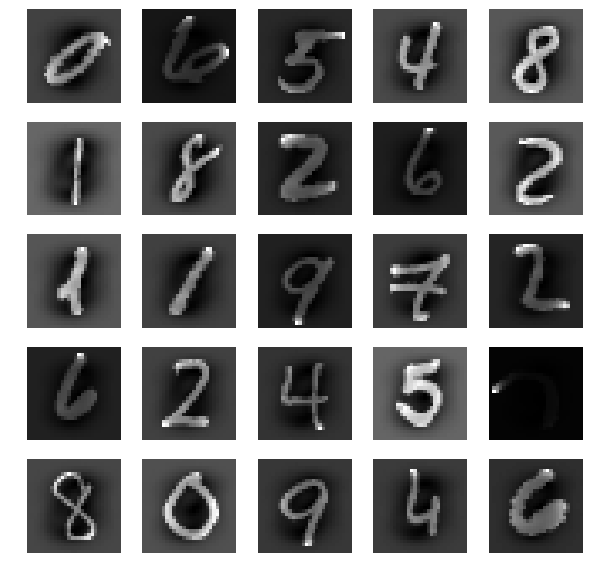

In [36]:
fig = plt.figure(figsize=(10,10))
(num_rows, num_cols) = (5, 5)
for i in range(0, num_rows * num_cols):
    img = X_train[i].reshape(28, 28)
  
    ax  = fig.add_subplot(num_rows, num_cols, i+1)
    _ = ax.set_axis_off()
    
    _ = plt.imshow(img, cmap="gray")

### Fit a model

In [37]:
X_train.shape, y_train.shape

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / train_samples,  # n.b. C is 1/(regularization penalty)
                         multi_class='multinomial',
                         # penalty='l1',   # n.b., "l1" loss: sparsity (number of non-zero) >> "l2" loss (dafault)
                         solver='saga', tol=0.1)

# Fit the model
clf.fit(X_train, y_train)

((5000, 784), (5000,))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

Let's be clear on the number of coefficients we estimated

- The $(28, 28)$ pixel matrix is flattened into $28 * 28 = 784$ features
- We are doing OvA to get $10$ binary classiifers, one for each digit class
    - technically, according to `LogisticRegression?`, `multinomial` use Cross Entropy loss

In [38]:
print("Coefficients dimension: ", clf.coef_.shape)
np.sum(clf.coef_ == 0, axis=1)

Coefficients dimension:  (10, 784)


array([121, 121, 121, 121, 121, 121, 121, 121, 121, 121])

In [39]:
# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)

print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )
print("Test score with {p} penalty:{s:.4f}".format(p=clf.penalty, s=score) )

Sparsity with l2 penalty: 15.43.
Test score with l2 penalty:0.8676


### Plot the coefficients, try to interpret

What do the regression coefficients mean ?

We'll deal with this more deeply in the module on Becoming A Successful Data Scientist but for now, let's visualize:
- low weights (e.g., negative) are black
- high weights are white

Coefficients shape (10, 784), range from -0.08 to 0.08


Text(0.5, 0.98, 'Classification vector for...')

Example run in 10.109 s


/home/kjp/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


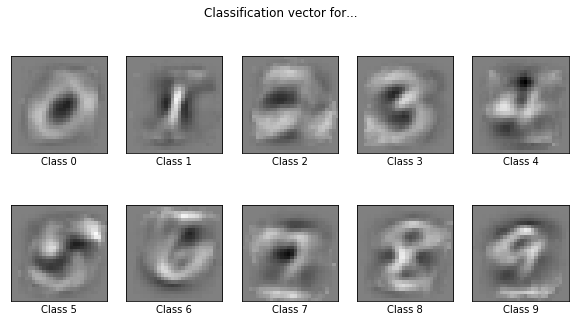

In [40]:
# Plot the coefficients (length 784) for each of the 10 digits
print("Coefficients shape {s}, range from {mn:.2f} to {mx:.2f}".format(s=clf.coef_.shape, mn= clf.coef_.min(), mx=clf.coef_.max()) )

fig = plt.figure(figsize=(10, 5))
coef = clf.coef_.copy()


(num_rows, num_cols) = (2,5)

scale = np.abs(coef).max()
for i in range(10):
    ax = fig.add_subplot(num_rows, num_cols, i+1)

    # Show the coefficients for digit i
    # Reshape it from (784,) to (28, 28) so can interpret it
    _ = ax.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap="gray", #plt.cm.RdBu, 
                   vmin=-scale, vmax=scale)
    
    _ = ax.set_xticks(())
    _ = ax.set_yticks(())
    _ = ax.set_xlabel('Class %i' % i)
    
fig.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
_ = fig.show()

## Model diagnostics: Classification report, confusion matrix

We'll deal with this more deeply in the module on Becoming A Successful Data Scientist but for now:


In [41]:
# Now predict the value of the digit on the second half:
expected = y_test
predicted = clf.predict(X_test)

confusion_mat = metrics.confusion_matrix(expected, predicted)



### Show the math beind precison and recall

In [42]:
print("Confusion matrix shape: ", confusion_mat.shape)
print("Confusion matrix col sums: ", np.sum(confusion_mat, axis=0))
print("Confusion matrix row sums: ", np.sum(confusion_mat, axis=1))

# Compute recall by hand
for i in range(0,10):
    # True positives are on the diagonal
    TP = confusion_mat[i,i]
    
    # False positives
    # Column i contains the observations that were classified (correctly or incorrectly) as i
    FP =np.sum(confusion_mat, axis=0)[i] -TP
    
    num_true_i = np.sum(confusion_mat, axis=1)[i]
    num_classified_i = np.sum(confusion_mat, axis=0)[i]
    
    recall    = TP/num_true_i
    precision = TP/num_classified_i
    
    print("{i}: precision {p:3.2f}, recall {r:3.2f}".format(i=i, r=recall, p=precision) )

Confusion matrix shape:  (10, 10)
Confusion matrix col sums:  [1008 1338  931 1025  947  771 1069 1063  864  984]
Confusion matrix row sums:  [ 976 1112  995 1052  962  885 1031 1046  985  956]
0: precision 0.92, recall 0.95
1: precision 0.81, recall 0.98
2: precision 0.88, recall 0.82
3: precision 0.86, recall 0.84
4: precision 0.90, recall 0.89
5: precision 0.88, recall 0.77
6: precision 0.89, recall 0.92
7: precision 0.88, recall 0.89
8: precision 0.86, recall 0.75
9: precision 0.82, recall 0.84


In [43]:
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))



Classification report for classifier LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       976
           1       0.81      0.98      0.89      1112
           2       0.88      0.82      0.85       995
           3       0.86      0.84      0.85      1052
           4       0.90      0.89      0.89       962
           5       0.88      0.77      0.82       885
           6       0.89      0.92      0.91      1031
           7       0.88      0.89      0.88      1046
           8       0.86      0.75      0.80       985
           9       0.82      0.84      0.83       956

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87

### Confusion matrix

In [44]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        # Normalize by row sums
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around( 100 * cm_pct, decimals=0).astype(int)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Plot coordinate system has origin in upper left corner
        # -  coordinates are (horizontal offset, vertical offset)
        # -  so cm[i,j] should appear in plot coordinate (j,i)
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization


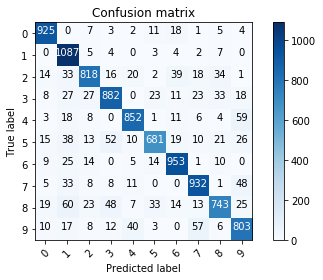

In [45]:
plot_confusion_matrix(confusion_mat, range(10))

#### Recall is the diagonal of the normalized confusion matrix

Normalized confusion matrix


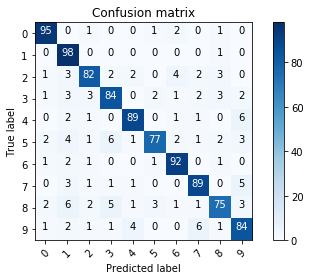

In [46]:
# plot_confusion_matrix( np.around( confusion_mat_pct * 100, decimals=0).astype(int), range(10) )
plot_confusion_matrix(confusion_mat, range(10), normalize=True)

# Recap

- We saw how to deal with a non-numeric targets and features
- We saw some real-life transformation
    - We saw a real Data Transformation pipeline
        - feature union
        - was able to transform Pandas DataFrame !
        - data cleaning via Imputer
        - One Hot Encoding

- Multiple models for no extra cost !
    - snuck in RandomForest and SVC classifiers - more later
    - only 1 line (instantiate model) changes !

- First pass and data cleaning - more later


In [47]:
print("Done")

Done
